In [1]:
import yasa
import numpy as np
import pandas as pd
import mne
import scipy.stats as sp_stats
import scipy.signal as sp_sig
import antropy as ant
from scipy.integrate import simps
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import robust_scale
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC

pd.options.display.precision = 10

In [2]:
####################
# MAIN PARAMETERS
####################

# Bandpass filter
freq_broad = (0.1, 500)
# FFT & bandpower parameters
sr = 1000
bands = [
    (0.1, 4, 'delta'), (4, 8, 'theta'),
    (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
    (30, 100, 'gamma'), (100, 300, 'fast')
]

In [3]:
def bandpower_from_psd_ndarray(psd, freqs, bands=[(0.5, 4, 'Delta'),
                               (4, 8, 'Theta'), (8, 12, 'Alpha'),
                               (12, 16, 'Sigma'), (16, 30, 'Beta'),
                               (30, 40, 'Gamma')], relative=True):
    # Type checks
    assert isinstance(bands, list), 'bands must be a list of tuple(s)'
    assert isinstance(relative, bool), 'relative must be a boolean'

    # Safety checks
    freqs = np.asarray(freqs)
    psd = np.asarray(psd)
    assert freqs.ndim == 1, 'freqs must be a 1-D array of shape (n_freqs,)'
    assert psd.shape[-1] == freqs.shape[-1], 'n_freqs must be last axis of psd'

    # Extract frequencies of interest
    all_freqs = np.hstack([[b[0], b[1]] for b in bands])
    fmin, fmax = min(all_freqs), max(all_freqs)
    idx_good_freq = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs = freqs[idx_good_freq]
    res = freqs[1] - freqs[0]

    # Trim PSD to frequencies of interest
    psd = psd[..., idx_good_freq]

    # Check if there are negative values in PSD
    if (psd < 0).any():
        msg = (
            "There are negative values in PSD. This will result in incorrect "
            "bandpower values. We highly recommend working with an "
            "all-positive PSD. For more details, please refer to: "
            "https://github.com/raphaelvallat/yasa/issues/29")
        logger.warning(msg)

    # Calculate total power
    total_power = simps(psd, dx=res, axis=-1)
    total_power = total_power[np.newaxis, ...]

    # Initialize empty array
    bp = np.zeros((len(bands), *psd.shape[:-1]), dtype=np.float)

    # Enumerate over the frequency bands
    labels = []
    for i, band in enumerate(bands):
        b0, b1, la = band
        labels.append(la)
        idx_band = np.logical_and(freqs >= b0, freqs <= b1)
        bp[i] = simps(psd[..., idx_band], dx=res, axis=-1)

    if relative:
        bp /= total_power
    return bp

def get_metrics(cm):
    if len(cm) == 0:
        cm = np.zeros((2,2), dtype=int)
    if np.squeeze(cm).ndim < 2:
        new_cm = np.zeros((2,2), dtype=int)
        new_cm[1, 1] = int(cm[0][0])
        cm = new_cm
    numerator = cm[0, 0] + cm[1, 1]
    denominator = cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0]
    accuracy = numerator / denominator
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    numerator = precision * recall
    denominator = (0.25 * precision) + recall
    f_score = 1.25 * numerator / denominator
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f_score': f_score}

In [4]:
def format_raw(edf, side):
    raw = mne.io.read_raw_edf(edf)
    spikes = raw.annotations
    spikes_df = pd.DataFrame(spikes)
    end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
    spikes_df = spikes_df[spikes_df['onset'] < end_onset]
    spikes_df = spikes_df[spikes_df['description'].str.contains(side + 't')]
    # spikes_df.onset = spikes_df.onset.astype(int)
    spikes_df = spikes_df.drop_duplicates(subset=['onset'])
    raw_data = raw.crop(tmax=end_onset).pick_channels([side + 'AH1']).resample(sr).get_data()[0]
    
    epochs = []
    epochs_zscore = []
    window_size = int(sr / 4)
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)
            epochs_zscore.append(sp_stats.zscore(curr_block))
    
    y_windows = np.zeros(len(epochs))
    for onset in spikes_df['onset']:
        y_windows[int(onset * 1000 / window_size + 1)] = 1
        
    return np.array(epochs), np.array(epochs_zscore), y_windows

In [5]:
def calc_features(epochs):
    # Calculate standard descriptive statistics
    hmob, hcomp = ant.hjorth_params(epochs, axis=1)

    feat = {
        'std': np.std(epochs, ddof=1, axis=1),
        'iqr': sp_stats.iqr(epochs, rng=(25, 75), axis=1),
        'skew': sp_stats.skew(epochs, axis=1),
        'kurt': sp_stats.kurtosis(epochs, axis=1),
        'nzc': ant.num_zerocross(epochs, axis=1),
        'hmob': hmob,
        'hcomp': hcomp
    }

    # Calculate spectral power features (for EEG + EOG)
    freqs, psd = sp_sig.welch(epochs, sr)
    bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
    for j, (_, _, b) in enumerate(bands):
        feat[b] = bp[j]

    # Add power ratios for EEG
    delta = feat['delta']
    feat['dt'] = delta / feat['theta']
    feat['ds'] = delta / feat['sigma']
    feat['db'] = delta / feat['beta']
    feat['dg'] = delta / feat['gamma']
    feat['df'] = delta / feat['fast']
    feat['at'] = feat['alpha'] / feat['theta']
    feat['gt'] = feat['gamma'] / feat['theta']
    feat['ft'] = feat['fast'] / feat['theta']
    feat['ag'] = feat['gamma'] / feat['alpha']
    feat['af'] = feat['fast'] / feat['alpha']

    # Add total power
    idx_broad = np.logical_and(
        freqs >= freq_broad[0], freqs <= freq_broad[1])
    dx = freqs[1] - freqs[0]
    feat['abspow'] = np.trapz(psd[:, idx_broad], dx=dx)

    # Calculate entropy and fractal dimension features
    feat['perm'] = np.apply_along_axis(
        ant.perm_entropy, axis=1, arr=epochs, normalize=True)
    feat['higuchi'] = np.apply_along_axis(
        ant.higuchi_fd, axis=1, arr=epochs)
    feat['petrosian'] = ant.petrosian_fd(epochs, axis=1)

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    feat.index.name = 'epoch'

    #############################
    # SMOOTHING & NORMALIZATION
    #############################

    # Apply centered rolling average (15 epochs = 7 min 30)
    # Triang: [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.,
    #          0.875, 0.75, 0.625, 0.5, 0.375, 0.25, 0.125]
    rollc = feat.rolling(
        window=2, center=True, min_periods=1, win_type='triang').mean()
    rollc[rollc.columns] = robust_scale(rollc, quantile_range=(5, 95))
    rollc = rollc.add_suffix('_cmin_norm')

    # Now look at the past 2 minutes
    rollp = feat.rolling(window=1, min_periods=1).mean()
    rollp[rollp.columns] = robust_scale(rollp, quantile_range=(5, 95))
    rollp = rollp.add_suffix('_pmin_norm')

    # Add to current set of features
    feat = feat.join(rollc).join(rollp)
    # Remove cols of only zeros
    feat = feat.loc[:, (feat != 0).any(axis=0)]
    
    return feat

In [17]:
x_all = np.empty((0, 250))
x_all_zscore = np.empty((0, 250))
y_all = np.empty(0)
for subj in ['396', '398', '402', '406', '415', '416']:
    for side in ['R', 'L']:
        if not (subj == '396' and side == 'R'):
            x, x_zscore, y = format_raw(f'C:\\Lilach\\{subj}_for_tag_filtered.edf', side)
            x_all = np.concatenate((x_all, x))
            x_all_zscore = np.concatenate((x_all_zscore, x_zscore))
            y_all = np.concatenate((y_all, y))

Extracting EDF parameters from C:\Lilach\396_for_tag_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Lilach\398_for_tag_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Lilach\398_for_tag_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Lilach\402_for_tag_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Lilach\402_for_tag_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Lilach\406_for_tag_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Lilach\406_for_tag_filtered.edf...
EDF file detected
S

In [18]:
# x_406, x_zscore_406, y_406 = format_raw('C:\\Lilach\\406_for_tag_filtered.edf', 'R')
# x_415, x_zscore_415, y_415 = format_raw('C:\\Lilach\\415_for_tag_filtered.edf', 'R')
# x_416, x_zscore_416, y_416 = format_raw('C:\\Lilach\\416_for_tag_filtered.edf', 'R')
# x_all = np.concatenate((x_406, x_415, x_416))
# x_all_zscore = np.concatenate((x_zscore_406, x_zscore_415, x_zscore_416))
# y_all = np.concatenate((y_406, y_415, y_416))

In [19]:
feat_all = calc_features(x_all)
feat_all_zscore = calc_features(x_all_zscore)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:39: Deprecat

[17:56:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


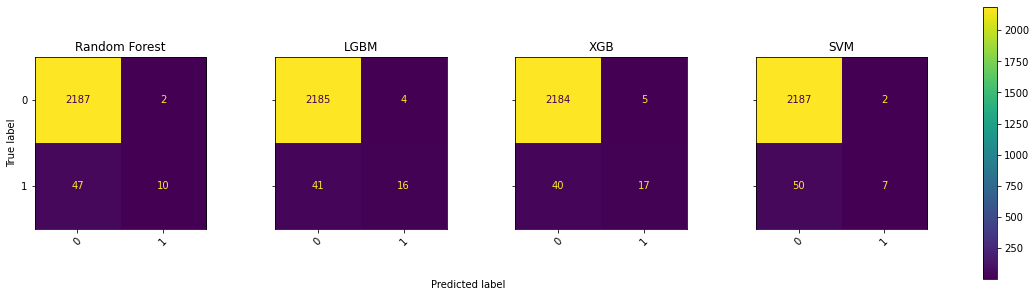

In [20]:
X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    "SVM": SVC()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

[17:56:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


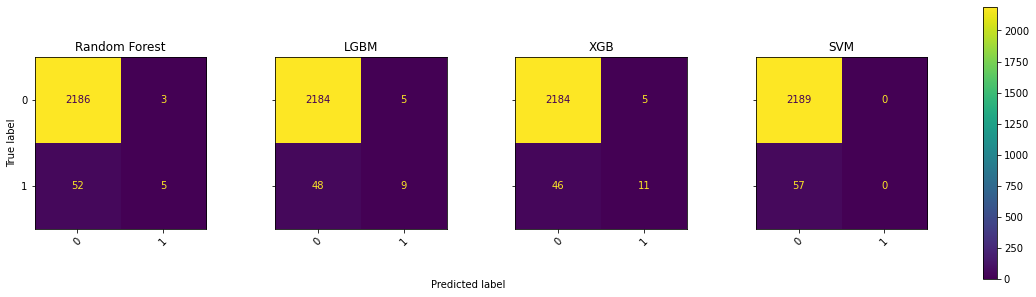

In [21]:
X_train, X_test, y_train, y_test = train_test_split(feat_all_zscore, y_all, stratify=y_all)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    "SVM": SVC()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [16]:
np.empty(0)

array([], dtype=float64)